# HellaSwag EDA
EDA, Adjustments, Balancing, and Exporting

## Imports & Settings

In [1]:
import os
os.chdir('..')
# os.getcwd( )

In [2]:
from utils import *

import re
import nltk
import string
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import datasets
from datasets import load_dataset, load_metric, Dataset

## Load Dataset
The HellaSwag dataset is available via HuggingFace's Datasets library.

In [3]:
# load the hellaswag dataset and view
dataset = load_dataset("hellaswag")

Found cached dataset hellaswag (/Users/jarradjinx/.cache/huggingface/datasets/hellaswag/default/0.1.0/c37cd37196278995f42bc32f532730ae9b0d5f0f4a2d3b97735c17ff3ad67169)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# save dataset locally as a backup
dataset.save_to_disk("data/inter_HellaSwag/source_hellaswag.hf")

Saving the dataset (0/1 shards):   0%|          | 0/39905 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10003 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10042 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label'],
        num_rows: 39905
    })
    test: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label'],
        num_rows: 10003
    })
    validation: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label'],
        num_rows: 10042
    })
})

Loading in the datasets, we note that the "test" split provided does not have labels. This dataset is likely for impartial, 3rd party evaluation. As we do not have the true labels, we will not use this dataset. Rather, we will split the training dataset in order to create a holdout test set.

In [6]:
hellaswag_test_df = dataset['test'].to_pandas()

hellaswag_test_df.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
0,14,Wakeboarding,A man is being pulled on a water ski as he flo...,he,A man is being pulled on a water ski as he flo...,[mounts the water ski and tears through the wa...,activitynet~v_-5KAycAQlC4,test,indomain,
1,71,Javelin throw,A huge crowd is in the stands in an arena. A m...,several men,A huge crowd is in the stands in an arena. A m...,"[are water boarding in a river., are shown thr...",activitynet~v_-fjUWhSM6Hc,test,indomain,
2,73,Javelin throw,The man that threw the javelin celebrates. Ano...,several men,The man that threw the javelin celebrates. Ano...,"[run out to where the javelin lands again., th...",activitynet~v_-fjUWhSM6Hc,test,indomain,
3,76,Javelin throw,The second man to throw the javelin and a man ...,the same men,The second man to throw the javelin and a man ...,[do the same action but in different locations...,activitynet~v_-fjUWhSM6Hc,test,indomain,
4,78,Javelin throw,The same men run to the the javelin's landing ...,again,The same men run to the the javelin's landing ...,"[, another man does not throw his javelin., th...",activitynet~v_-fjUWhSM6Hc,test,indomain,


In [7]:
# we will need to view and prep the datasets
# this is more easily done as dataframes
hellaswag_train_df = dataset['train'].to_pandas()
hellaswag_validate_df = dataset['validation'].to_pandas() 

## View Dataset

Looking at the dataset head, we see that the ending options are collating into arrays. We'll need to split these.

In [8]:
hellaswag_train_df.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
0,4,Removing ice from car,"Then, the man writes over the snow covering th...",then,"Then, the man writes over the snow covering th...","[, the man adds wax to the windshield and cuts...",activitynet~v_-1IBHYS3L-Y,train,indomain,3
1,8,Baking cookies,A female chef in white uniform shows a stack o...,the pans,A female chef in white uniform shows a stack o...,"[contain egg yolks and baking soda., are then ...",activitynet~v_-2dxp-mv2zo,train,indomain,3
2,9,Baking cookies,A female chef in white uniform shows a stack o...,a knife,A female chef in white uniform shows a stack o...,[is seen moving on a board and cutting out its...,activitynet~v_-2dxp-mv2zo,train,indomain,3
3,12,Baking cookies,A tray of potatoes is loaded into the oven and...,a large tray of meat,A tray of potatoes is loaded into the oven and...,"[is placed onto a baked potato., , ls, and pic...",activitynet~v_-2dxp-mv2zo,train,indomain,3
4,27,Getting a haircut,The man in the center is demonstrating a hairs...,the man in the blue shirt,The man in the center is demonstrating a hairs...,[is standing on the sponge cutting the hair of...,activitynet~v_-JqLjPz-07E,train,indomain,2


In [9]:
hellaswag_train_df.iloc[30812]

ind                                                           32483
activity_label                            Computers and Electronics
ctx_a             [header] How to download lynda videos [title] ...
ctx_b                                                              
ctx               [header] How to download lynda videos [title] ...
endings           [[substeps] If necessary, run a quick scan to ...
source_id                                             wikihow~53527
split                                                         train
split_type                                                 indomain
label                                                             2
Name: 30812, dtype: object

We will need to split the endings for the validation set as well.

In [10]:
hellaswag_validate_df.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
0,24,Roof shingle removal,A man is sitting on a roof.,he,A man is sitting on a roof. he,"[is using wrap to wrap a pair of skis., is rip...",activitynet~v_-JhWjGDPHMY,val,indomain,3
1,92,Clean and jerk,A lady walks to a barbell. She bends down and ...,the lady,A lady walks to a barbell. She bends down and ...,"[swings and lands in her arms., pulls the barb...",activitynet~v_-lJS58hyo1c,val,zeroshot,3
2,106,Canoeing,Two women in a child are shown in a canoe whil...,the child and a different man,Two women in a child are shown in a canoe whil...,[are then shown paddling down a river in a boa...,activitynet~v_-xQvJmC2jhk,val,indomain,2
3,114,High jump,A boy is running down a track.,the boy,A boy is running down a track. the boy,"[runs into a car., gets in a mat., lifts his b...",activitynet~v_-zHX3Gdx6I4,val,zeroshot,2
4,116,High jump,The boy lifts his body above the height of a p...,the boy,The boy lifts his body above the height of a p...,"[turns his body around on the mat., gets up fr...",activitynet~v_-zHX3Gdx6I4,val,zeroshot,1


In [11]:
hellaswag_train_df['label'].unique()

array(['3', '2', '0', '1'], dtype=object)

## View Label Distribution
Below we find that the distribution of labels is fairly even.

[Text(0, 0, '10021'),
 Text(0, 0, '9867'),
 Text(0, 0, '9986'),
 Text(0, 0, '10031')]

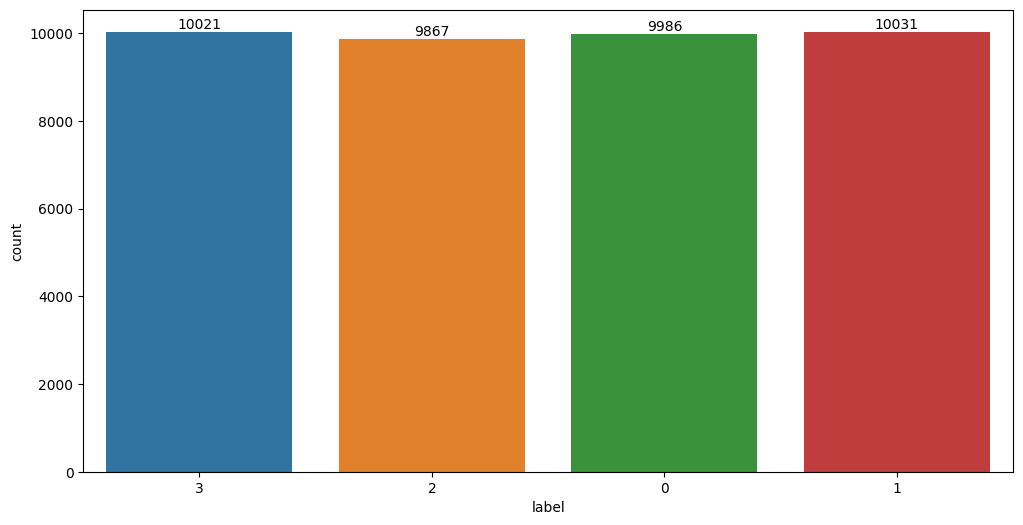

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=hellaswag_train_df)
ax.bar_label(ax.containers[0])

## Prep Dataset

### Split Endings

In [13]:
# split the "endings" column into constituent columns 
hellaswag_train_df[['ending0','ending1','ending2','ending3']] = pd.DataFrame(hellaswag_train_df['endings'].tolist(), index= hellaswag_train_df.index)
hellaswag_validate_df[['ending0','ending1','ending2','ending3']] = pd.DataFrame(hellaswag_validate_df['endings'].tolist(), index= hellaswag_validate_df.index)

In [14]:
hellaswag_train_df.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label,ending0,ending1,ending2,ending3
0,4,Removing ice from car,"Then, the man writes over the snow covering th...",then,"Then, the man writes over the snow covering th...","[, the man adds wax to the windshield and cuts...",activitynet~v_-1IBHYS3L-Y,train,indomain,3,", the man adds wax to the windshield and cuts it.",", a person board a ski lift, while two men sup...",", the man puts on a christmas coat, knitted wi...",", the man continues removing the snow on his car."
1,8,Baking cookies,A female chef in white uniform shows a stack o...,the pans,A female chef in white uniform shows a stack o...,"[contain egg yolks and baking soda., are then ...",activitynet~v_-2dxp-mv2zo,train,indomain,3,contain egg yolks and baking soda.,are then sprinkled with brown sugar.,are placed in a strainer on the counter.,are filled with pastries and loaded into the o...
2,9,Baking cookies,A female chef in white uniform shows a stack o...,a knife,A female chef in white uniform shows a stack o...,[is seen moving on a board and cutting out its...,activitynet~v_-2dxp-mv2zo,train,indomain,3,is seen moving on a board and cutting out its ...,"hits the peeled cheesecake, followed by sliced...",etches a shape into the inside of the baked pans.,is used to cut cylinder shaped dough into rounds.
3,12,Baking cookies,A tray of potatoes is loaded into the oven and...,a large tray of meat,A tray of potatoes is loaded into the oven and...,"[is placed onto a baked potato., , ls, and pic...",activitynet~v_-2dxp-mv2zo,train,indomain,3,is placed onto a baked potato.,", ls, and pickles are placed in the oven.",is poured into a midden.,is prepared then it is removed from the oven b...
4,27,Getting a haircut,The man in the center is demonstrating a hairs...,the man in the blue shirt,The man in the center is demonstrating a hairs...,[is standing on the sponge cutting the hair of...,activitynet~v_-JqLjPz-07E,train,indomain,2,is standing on the sponge cutting the hair of ...,is doing the hairstyle with his hand and the h...,sits on the chair next to the sink.,is being shown eye to eye.


### Cast Labels as Int

In [15]:
hellaswag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39905 entries, 0 to 39904
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ind             39905 non-null  int32 
 1   activity_label  39905 non-null  object
 2   ctx_a           39905 non-null  object
 3   ctx_b           39905 non-null  object
 4   ctx             39905 non-null  object
 5   endings         39905 non-null  object
 6   source_id       39905 non-null  object
 7   split           39905 non-null  object
 8   split_type      39905 non-null  object
 9   label           39905 non-null  object
 10  ending0         39905 non-null  object
 11  ending1         39905 non-null  object
 12  ending2         39905 non-null  object
 13  ending3         39905 non-null  object
dtypes: int32(1), object(13)
memory usage: 4.1+ MB


In [16]:
# we need to ensure that the labels are int
hellaswag_train_df['label'] = hellaswag_train_df['label'].astype('int64')
hellaswag_validate_df['label'] = hellaswag_validate_df['label'].astype('int64')

In [17]:
hellaswag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39905 entries, 0 to 39904
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ind             39905 non-null  int32 
 1   activity_label  39905 non-null  object
 2   ctx_a           39905 non-null  object
 3   ctx_b           39905 non-null  object
 4   ctx             39905 non-null  object
 5   endings         39905 non-null  object
 6   source_id       39905 non-null  object
 7   split           39905 non-null  object
 8   split_type      39905 non-null  object
 9   label           39905 non-null  int64 
 10  ending0         39905 non-null  object
 11  ending1         39905 non-null  object
 12  ending2         39905 non-null  object
 13  ending3         39905 non-null  object
dtypes: int32(1), int64(1), object(12)
memory usage: 4.1+ MB


In [18]:
print(hellaswag_train_df['ctx'][600])
print(hellaswag_train_df['endings'][600])
print(hellaswag_train_df['label'][600])

A woman wearing an apron is talking and picks up a bucket with supplies in it. She grabs a brush and cleans a window. she
['then takes a knife and starts cleaning the window.'
 'grabs a squeegee and removes the excess water from the window.'
 'sets it on a table and grabs more supplies to clean another window.'
 'points at the box.']
1


## Adjust & Export Datasets for Train/Validate/Test

In [19]:
# shuffle dataframe and reset index
hellaswag_train_df = hellaswag_train_df.sample(frac=1, random_state=1).reset_index(drop=True)

hellaswag_train_df.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label,ending0,ending1,ending2,ending3
0,14721,Food and Entertaining,[header] How to thicken frosting [title] Add m...,,[header] How to thicken frosting [title] Add m...,"[Where required, spoon additional powdered sug...",wikihow~24341,train,indomain,1,"Where required, spoon additional powdered suga...",Sprinkle an additional 1 to 2 tbsp (15 to 30 m...,"Just a little at a time, or you won't get the ...","If you add in too much added sugar, you won't ..."
1,41688,Throwing darts,A little boy is throwing darts at a board.,he,A little boy is throwing darts at a board. he,"[throws a dart at a ball, then turns around., ...",activitynet~v_JKVOi9DE8Hs,train,indomain,3,"throws a dart at a ball, then turns around.","hits the board with a dart, and slides to the ...",walks towards the board and puts his darts down.,"walks over to the target, looking at where the..."
2,4196,Beer pong,Guys point at the camera and laugh. A guy take...,a guy,Guys point at the camera and laugh. A guy take...,[throws a golf ball with his back toward the t...,activitynet~v_m1pNOYN-DoI,train,indomain,0,throws a golf ball with his back toward the ta...,stands on a court and pushes a ball into a cup.,sits and talks with a friend while he intervie...,shoots holes in the table.
3,47931,Food and Entertaining,[header] How to make a chocolate cookie dough ...,,[header] How to make a chocolate cookie dough ...,"[[step] Mix the milk, butter, vanilla, and egg...",wikihow~78890,train,indomain,2,"[step] Mix the milk, butter, vanilla, and eggs...",[step] Melt the white chocolate in a small sau...,"[step] In a large bowl, mix the salt, baking s...",[step] Combine the dry ingredients into a larg...
4,24410,Cars & Other Vehicles,[header] How to set up a restroom trailer [tit...,,[header] How to set up a restroom trailer [tit...,[This is the number of toilets and urinals tha...,wikihow~40259,train,indomain,0,This is the number of toilets and urinals that...,"[substeps] To assess the size of the trailer, ...",Most facilities should be built up to the near...,"The larger the station, the more people your a..."


In [20]:
hellaswag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39905 entries, 0 to 39904
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ind             39905 non-null  int32 
 1   activity_label  39905 non-null  object
 2   ctx_a           39905 non-null  object
 3   ctx_b           39905 non-null  object
 4   ctx             39905 non-null  object
 5   endings         39905 non-null  object
 6   source_id       39905 non-null  object
 7   split           39905 non-null  object
 8   split_type      39905 non-null  object
 9   label           39905 non-null  int64 
 10  ending0         39905 non-null  object
 11  ending1         39905 non-null  object
 12  ending2         39905 non-null  object
 13  ending3         39905 non-null  object
dtypes: int32(1), int64(1), object(12)
memory usage: 4.1+ MB


### Test Split

In [21]:
# get 1,655 sample
hellaswag_test = hellaswag_train_df.sample(4994, random_state=1)
hellaswag_test

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label,ending0,ending1,ending2,ending3
21968,25738,Rollerblading,Man is sanding in the middle of street skating.,another man,Man is sanding in the middle of street skating...,"[is sanding in a skate court., is in street wi...",activitynet~v_9UpVdljXQ4E,train,indomain,1,is sanding in a skate court.,is in street with him and are skating together.,is sanding in the middle of a street.,is adulnison in a z screup.
12082,33276,Snow tubing,We see writing stating the camera was dropped....,we,We see writing stating the camera was dropped....,"[see close ups of first people skating., see a...",activitynet~v_aeKIYkn99_Q,train,indomain,2,see close ups of first people skating.,see an animated title screen.,see a young man's face as he rides down the hill.,see the man putting on gear and then decoratin...
1313,8585,Food and Entertaining,[header] How to check your sperm count [title]...,,[header] How to check your sperm count [title]...,[You may need to ask questions about the tests...,wikihow~14128,train,indomain,1,You may need to ask questions about the tests....,Read the instructions carefully beforehand so ...,They then detect sperm or their bodies begin t...,[title] Ejaculate into the cup prior to testin...
38546,33047,Health,[header] How to prevent syphilis [title] Limit...,,[header] How to prevent syphilis [title] Limit...,[This increases your risk for developing syphi...,wikihow~54467,train,indomain,2,This increases your risk for developing syphil...,This increases the risk of the infection sprea...,Sexually active people who have only one partn...,Decreasing your number of sex partners can pre...
26801,36889,Roof shingle removal,"The clip flips, and the guy is closer to the c...",the guy,"The clip flips, and the guy is closer to the c...","[is walking away from the camera, he stops and...",activitynet~v_b3mJ5rPzDv8,train,indomain,3,"is walking away from the camera, he stops and ...",is the last to leave the camera frame.,walks back from the camera.,stops talking and looks straight at the camera.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16909,19479,Work World,[header] How to become a periodontist [title] ...,,[header] How to become a periodontist [title] ...,[[substeps] In addition to a bachelor's degree...,wikihow~32144,train,indomain,3,"[substeps] In addition to a bachelor's degree,...","To begin your practice, you must be a u.s. exp...",This degree will enable you to specialize in y...,You don't necessarily need to focus on pre-med...
30229,380,Relationships,[header] How to interest people right away [ti...,,[header] How to interest people right away [ti...,[They will likely be impressed and will be int...,wikihow~614,train,indomain,1,They will likely be impressed and will be inte...,Don't do the usual introduction while introduc...,"It's natural to feel awkward at first, especia...",Begin with :' hi! I'm jimmy! I've noticed you ...
26529,48881,Education and Communications,[header] How to write a conclusion for a resea...,,[header] How to write a conclusion for a resea...,[Keep the essay short and to the point. The mo...,wikihow~80469,train,indomain,1,Keep the essay short and to the point. The mor...,A good research paper will make the importance...,Limit the reader to only a few sentences. For ...,Deliver each aspect you wish to address all at...
33410,20273,Youth,[header] How to convince your parents to buy y...,,[header] How to convince your parents to buy y...,[Keep in mind that guinea pigs are deaf and ca...,wikihow~33467,train,indomain,1,Keep in mind that guinea pigs are deaf and can...,A few facts about guinea pigs to get you start...,"[substeps] Study the anatomy, age, sex, and li...","Find out the species, breed and quality of gui..."


In [22]:
# remove test set samples from dataset
hellaswag_train_df = hellaswag_train_df.drop(hellaswag_test.index)
hellaswag_train_df


,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label,ending0,ending1,ending2,ending3
0,14721,Food and Entertaining,[header] How to thicken frosting [title] Add m...,,[header] How to thicken frosting [title] Add m...,"[Where required, spoon additional powdered sug...",wikihow~24341,train,indomain,1,"Where required, spoon additional powdered suga...",Sprinkle an additional 1 to 2 tbsp (15 to 30 m...,"Just a little at a time, or you won't get the ...","If you add in too much added sugar, you won't ..."
1,41688,Throwing darts,A little boy is throwing darts at a board.,he,A little boy is throwing darts at a board. he,"[throws a dart at a ball, then turns around., ...",activitynet~v_JKVOi9DE8Hs,train,indomain,3,"throws a dart at a ball, then turns around.","hits the board with a dart, and slides to the ...",walks towards the board and puts his darts down.,"walks over to the target, looking at where the..."
2,4196,Beer pong,Guys point at the camera and laugh. A guy take...,a guy,Guys point at the camera and laugh. A guy take...,[throws a golf ball with his back toward the t...,activitynet~v_m1pNOYN-DoI,train,indomain,0,throws a golf ball with his back toward the ta...,stands on a court and pushes a ball into a cup.,sits and talks with a friend while he intervie...,shoots holes in the table.
4,24410,Cars & Other Vehicles,[header] How to set up a restroom trailer [tit...,,[header] How to set up a restroom trailer [tit...,[This is the number of toilets and urinals tha...,wikihow~40259,train,indomain,0,This is the number of toilets and urinals that...,"[substeps] To assess the size of the trailer, ...",Most facilities should be built up to the near...,"The larger the station, the more people your a..."
5,47011,Food and Entertaining,[header] How to make a windsock for children [...,,[header] How to make a windsock for children [...,[[substeps] Crayons can be customized or made ...,wikihow~77356,train,indomain,1,[substeps] Crayons can be customized or made f...,"If you use paint, be sure to let the paint dry...","You can paint the paper white, let it dry for ...","Pick up crayons or cards, markers or stickers ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39899,13620,Sports and Fitness,[header] How to be a better golfer [title] Wor...,,[header] How to be a better golfer [title] Wor...,[Find a few days that you can commit to workin...,wikihow~22544,train,indomain,2,Find a few days that you can commit to working...,The same is true for your shooting skills. Wor...,Putting is very important aspect of your short...,"The faster you play, the better you will score..."
39900,27420,Getting a tattoo,"A woman in a purple sun dress, wearing pink su...",a woman,"A woman in a purple sun dress, wearing pink su...",[is placed on top of a black table with the hi...,activitynet~v_smh90DBXsBg,train,indomain,1,is placed on top of a black table with the hig...,is shown sitting in a chair and receiving a ta...,in a purple shirt board slides against the wal...,in a trench coat walks up to a truck and opens...
39902,17676,Putting on makeup,We see a makeup artist talk while sitting fron...,the lady,We see a makeup artist talk while sitting fron...,[puts eye shadow over the eyelashes and makes ...,activitynet~v_0pcrpO0Gd8M,train,indomain,1,puts eye shadow over the eyelashes and makes a...,talks the puts glue on the lash.,displays them in the mirror.,looks in the mirror and smiles.
39903,42026,Powerbocking,A woman takes a few steps with a pair of jumpi...,the woman,A woman takes a few steps with a pair of jumpi...,"[then performs her routine., is joined by a ma...",activitynet~v_N4wKdmmX0lk,train,indomain,1,then performs her routine.,is joined by a man who is also jumping around ...,turns around and begins jumping without the eq...,falls to the ground and swings the camera arou...


### Train Split

[Text(0, 0, '8771'),
 Text(0, 0, '8765'),
 Text(0, 0, '8650'),
 Text(0, 0, '8725')]

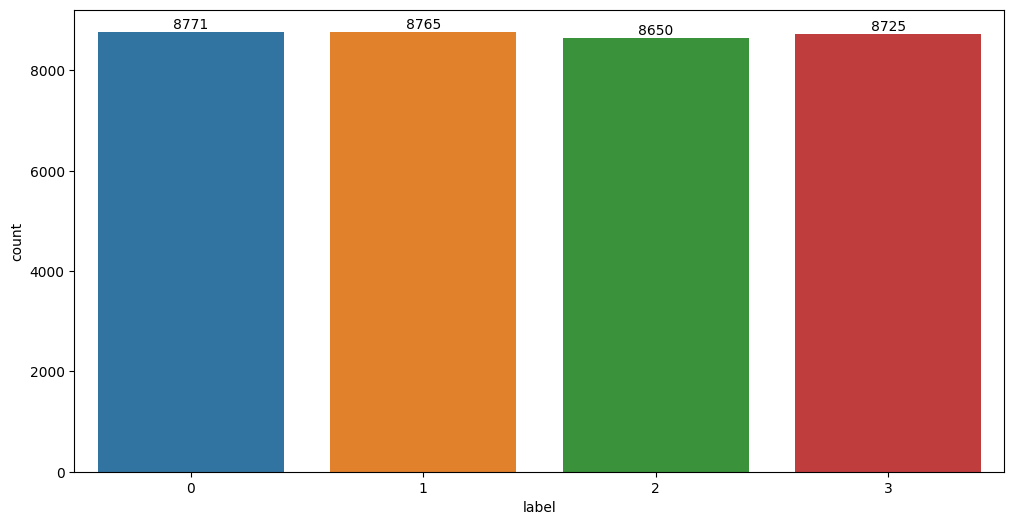

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=hellaswag_train_df)
ax.bar_label(ax.containers[0])

In [24]:
# get samples for each class equal to the number of available samples for the smallest class
hellaswag_train = hellaswag_train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), min(np.unique(hellaswag_train_df['label'], return_counts=True)[1])), random_state=1).sample(frac=1, random_state=1))
hellaswag_train

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label,ending0,ending1,ending2,ending3
22567,21817,Home and Garden,[header] How to tell when lotus root has gone ...,,[header] How to tell when lotus root has gone ...,"[If your root has mold or mildew on it, you sh...",wikihow~36029,train,indomain,0,"If your root has mold or mildew on it, you sho...","[substeps] Rose dimes, or similarly rancid loo...","If this occurs, it has gone bad. Mildew, for i...",[substeps] Mildew may also be a sign of rot. L...
13502,30281,Home and Garden,[header] How to wash linen curtains [title] Ma...,,[header] How to wash linen curtains [title] Ma...,[[title] Take the curtains down from the windo...,wikihow~49909,train,indomain,0,[title] Take the curtains down from the window...,"If the backing is set behind curtains, wash it...",Decide which fabric type you want to wash your...,[substeps] Choose a machine with a full-speed ...
23205,15954,Food and Entertaining,[header] How to handle late whelping in dogs [...,,[header] How to handle late whelping in dogs [...,[It can also show how many pups she has. For i...,wikihow~26413,train,indomain,0,It can also show how many pups she has. For in...,"This is most reliable for early pregnancies, b...","If the owner wants to do an x-ray, the vet wou...",X-rays can be quite pricey and often the resul...
3776,25689,Food and Entertaining,[header] How to make a green candy buffet [tit...,,[header] How to make a green candy buffet [tit...,"[[substeps] Try bowls, glasses, sundae glasses...",wikihow~42339,train,indomain,0,"[substeps] Try bowls, glasses, sundae glasses,...",[title] Glue specific ingredient ingredients t...,"[substeps] As in with measuring, a medium size...",[substeps] As a strawberry shortcake competito...
12701,25193,Pets and Animals,[header] How to become a bollywood actress [ti...,,[header] How to become a bollywood actress [ti...,[Most communication from behind the scenes to ...,wikihow~41540,train,indomain,0,Most communication from behind the scenes to o...,It should be translated to be understood whene...,If you don't have a strong knowledge of this l...,You must have both master's and doctoral degre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38536,32605,Roof shingle removal,A worker removes moss from the top of a roof. ...,the roof,A worker removes moss from the top of a roof. ...,"[is shown being cleaned, shingles being sanded...",activitynet~v_ThYidZUtnuo,train,indomain,3,"is shown being cleaned, shingles being sanded,...",is photographed and straightened out.,is completed shopping cards are put together a...,is then really clean.
20802,43479,Polishing shoes,"Shoe polish supplies in a store, then people i...",then,"Shoe polish supplies in a store, then people i...","[, a man polish with nails and polish a boot.,...",activitynet~v_byVhCu3KH1g,train,indomain,3,", a man polish with nails and polish a boot.",", the woman screws the an shoes to polish an s...",", two people polish the boot using a croquet m...",", a girl polish the shoe of a woman using a cl..."
4894,15679,Food and Entertaining,[header] How to bake roman officers' bread [ti...,,[header] How to bake roman officers' bread [ti...,"[[step] In a small measuring cup, measure out ...",wikihow~25935,train,indomain,3,"[step] In a small measuring cup, measure out f...","[step] To do so, use a coffee grinder, an elec...",[step] Combine and knead the dough by hand. Co...,[step] Use a resealable glass/container with a...
25364,48717,Food and Entertaining,[header] How to start using ventrilo [title] D...,,[header] How to start using ventrilo [title] D...,[[title] Launch ventrilo from your computer. [...,wikihow~80193,train,indomain,3,[title] Launch ventrilo from your computer. [s...,"All you need to install is the "" windows usb i...",If you are a macromedia users user you will wa...,( the ventrilo client is licensed free for use...


### Double-Check Distribution
Our training set distribution is perfectly balanced while our validation and test sets are representative of the original dataset's distribution.

Text(0.5, 1.0, 'Train Set Label Distribution')

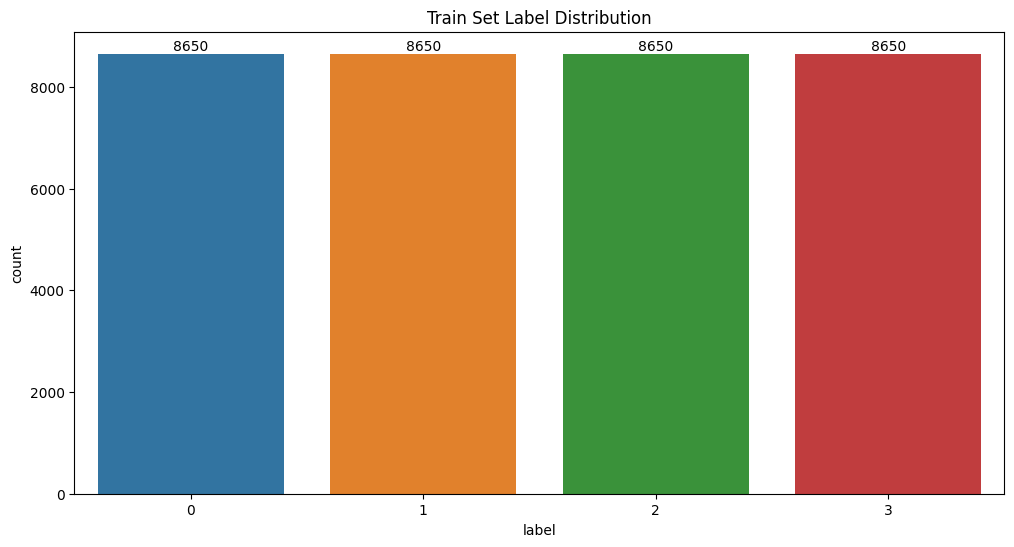

In [25]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=hellaswag_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

10042


Text(0.5, 1.0, 'Validation Set Label Distribution')

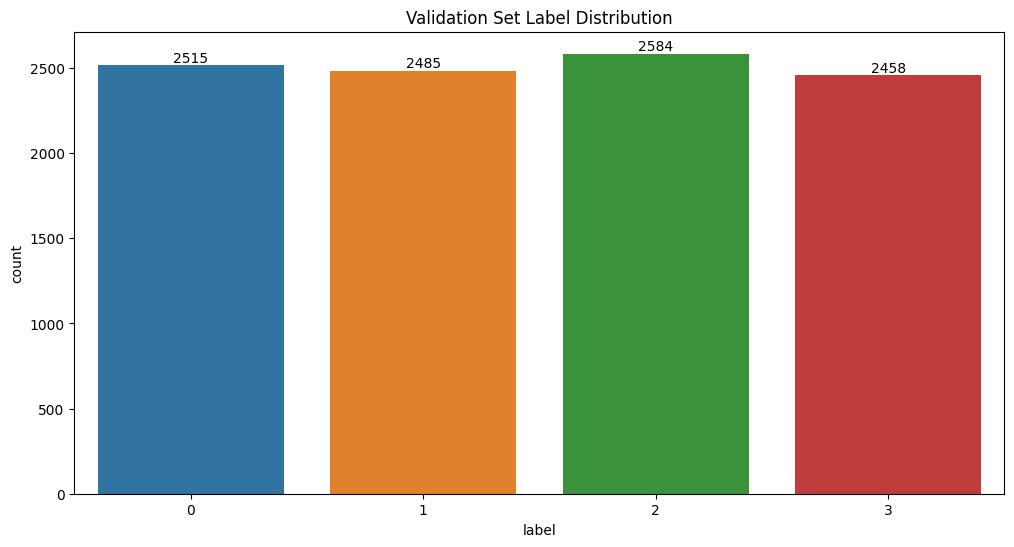

In [26]:
print(len(hellaswag_validate_df))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=hellaswag_validate_df)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

4994


Text(0.5, 1.0, 'Test Set Label Distribution')

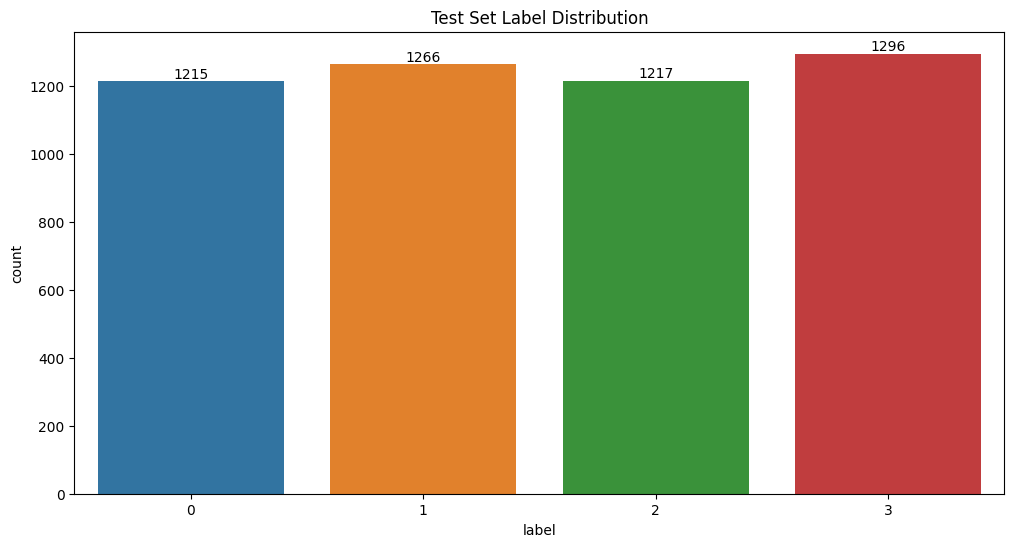

In [27]:
print(len(hellaswag_test))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=hellaswag_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

## Export Fine-Grain Datasets

In [28]:
# reconstitute the updated datafames into a DatasetDict object
fine_train_dataset = Dataset.from_pandas(hellaswag_train, preserve_index=False)
fine_validate_dataset = Dataset.from_pandas(hellaswag_validate_df, preserve_index=False)
fine_test_dataset = Dataset.from_pandas(hellaswag_test, preserve_index=False)
hellaswag_datasets = datasets.DatasetDict({"train":fine_train_dataset, 
                                          "validation":fine_validate_dataset, 
                                          "test":fine_test_dataset})

In [29]:
hellaswag_datasets

DatasetDict({
    train: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label', 'ending0', 'ending1', 'ending2', 'ending3'],
        num_rows: 34600
    })
    validation: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label', 'ending0', 'ending1', 'ending2', 'ending3'],
        num_rows: 10042
    })
    test: Dataset({
        features: ['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'endings', 'source_id', 'split', 'split_type', 'label', 'ending0', 'ending1', 'ending2', 'ending3'],
        num_rows: 4994
    })
})

In [30]:
hellaswag_datasets.save_to_disk("data/inter_HellaSwag/itesd_hellaswag_balanced.hf")

Saving the dataset (0/1 shards):   0%|          | 0/34600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10042 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4994 [00:00<?, ? examples/s]